In [1]:
import datetime
import pandas as pd
from xgboost import XGBRegressor
import hopsworks
import json
from functions import util
import os

In [2]:
today = datetime.datetime.now() - datetime.timedelta(0)
tomorrow = today + datetime.timedelta(days = 1)
today

datetime.datetime(2024, 11, 12, 11, 4, 20, 838424)

In [3]:
with open('./hopsworks-api-key.txt', 'r') as file:
     os.environ["HOPSWORKS_API_KEY"] = file.read().rstrip()
project = hopsworks.login()
fs = project.get_feature_store() 

secrets = util.secrets_api(project.name)
location_str = secrets.get_secret("SENSOR_LOCATION_JSON").value
location = json.loads(location_str)
country=location['country']
city=location['city']
street=location['street']

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1157273
Connected. Call `.close()` to terminate connection gracefully.
Connected. Call `.close()` to terminate connection gracefully.


In [4]:
feature_view = fs.get_feature_view(
    name='air_quality_fv',
    version=1,
)

In [5]:
mr = project.get_model_registry()

retrieved_model = mr.get_model(
    name="air_quality_xgboost_model",
    version=1,
)

# Download the saved model artifacts to a local directory
saved_model_dir = retrieved_model.download()

Connected. Call `.close()` to terminate connection gracefully.


In [6]:
# Loading the XGBoost regressor model and label encoder from the saved model directory
# retrieved_xgboost_model = joblib.load(saved_model_dir + "/xgboost_regressor.pkl")
retrieved_xgboost_model = XGBRegressor()

retrieved_xgboost_model.load_model(saved_model_dir + "/model.json")

# Displaying the retrieved XGBoost regressor model
retrieved_xgboost_model

XGBRegressor(base_score='9.0938354E1', booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['float', 'float', 'float', 'float'], gamma=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [7]:
weather_fg = fs.get_feature_group(
    name='weather',
    version=1,
)
batch_data = weather_fg.filter(weather_fg.date >= today).read(read_options={"use_hive": True})
batch_data

Finished: Reading data from Hopsworks, using Hive (23.04s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city
0,2024-11-17,24.40,0.0,14.058450,39.805527,guangzhou
1,2024-11-16,24.05,0.0,6.638072,12.528798,guangzhou
2,2024-11-14,24.55,0.4,9.832680,66.250500,guangzhou
3,2024-11-15,23.40,2.8,8.699793,65.556060,guangzhou
4,2024-11-13,26.90,0.0,14.578890,57.094753,guangzhou
5,2024-11-19,20.70,0.0,15.379206,20.556128,guangzhou
6,2024-11-18,23.80,0.0,15.459054,27.758451,guangzhou
7,2024-11-21,20.10,0.3,5.634891,26.564985,guangzhou
8,2024-11-20,21.40,0.0,13.049689,24.443953,guangzhou


In [8]:
batch_data['predicted_pm25'] = retrieved_xgboost_model.predict(
    batch_data[['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']])
batch_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25
0,2024-11-17,24.40,0.0,14.058450,39.805527,guangzhou,110.977463
1,2024-11-16,24.05,0.0,6.638072,12.528798,guangzhou,177.568207
2,2024-11-14,24.55,0.4,9.832680,66.250500,guangzhou,107.730034
3,2024-11-15,23.40,2.8,8.699793,65.556060,guangzhou,104.334167
4,2024-11-13,26.90,0.0,14.578890,57.094753,guangzhou,95.594109
5,2024-11-19,20.70,0.0,15.379206,20.556128,guangzhou,91.609337
6,2024-11-18,23.80,0.0,15.459054,27.758451,guangzhou,114.466232
7,2024-11-21,20.10,0.3,5.634891,26.564985,guangzhou,143.394440
8,2024-11-20,21.40,0.0,13.049689,24.443953,guangzhou,115.170860


In [9]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 7 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   date                         9 non-null      datetime64[ns]
 1   temperature_2m_mean          9 non-null      float64       
 2   precipitation_sum            9 non-null      float64       
 3   wind_speed_10m_max           9 non-null      float64       
 4   wind_direction_10m_dominant  9 non-null      float64       
 5   city                         9 non-null      object        
 6   predicted_pm25               9 non-null      float32       
dtypes: datetime64[ns](1), float32(1), float64(4), object(1)
memory usage: 596.0+ bytes


In [10]:
batch_data['street'] = street
batch_data['city'] = city
batch_data['country'] = country
# Fill in the number of days before the date on which you made the forecast (base_date)
batch_data['days_before_forecast_day'] = range(1, len(batch_data)+1)
batch_data = batch_data.sort_values(by=['date'])
batch_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25,street,country,days_before_forecast_day
4,2024-11-13,26.90,0.0,14.578890,57.094753,guangzhou,95.594109,shiwuzhong,china,5
2,2024-11-14,24.55,0.4,9.832680,66.250500,guangzhou,107.730034,shiwuzhong,china,3
3,2024-11-15,23.40,2.8,8.699793,65.556060,guangzhou,104.334167,shiwuzhong,china,4
1,2024-11-16,24.05,0.0,6.638072,12.528798,guangzhou,177.568207,shiwuzhong,china,2
0,2024-11-17,24.40,0.0,14.058450,39.805527,guangzhou,110.977463,shiwuzhong,china,1
6,2024-11-18,23.80,0.0,15.459054,27.758451,guangzhou,114.466232,shiwuzhong,china,7
5,2024-11-19,20.70,0.0,15.379206,20.556128,guangzhou,91.609337,shiwuzhong,china,6
8,2024-11-20,21.40,0.0,13.049689,24.443953,guangzhou,115.170860,shiwuzhong,china,9
7,2024-11-21,20.10,0.3,5.634891,26.564985,guangzhou,143.394440,shiwuzhong,china,8


In [11]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9 entries, 4 to 7
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   date                         9 non-null      datetime64[ns]
 1   temperature_2m_mean          9 non-null      float64       
 2   precipitation_sum            9 non-null      float64       
 3   wind_speed_10m_max           9 non-null      float64       
 4   wind_direction_10m_dominant  9 non-null      float64       
 5   city                         9 non-null      object        
 6   predicted_pm25               9 non-null      float32       
 7   street                       9 non-null      object        
 8   country                      9 non-null      object        
 9   days_before_forecast_day     9 non-null      int64         
dtypes: datetime64[ns](1), float32(1), float64(4), int64(1), object(3)
memory usage: 756.0+ bytes


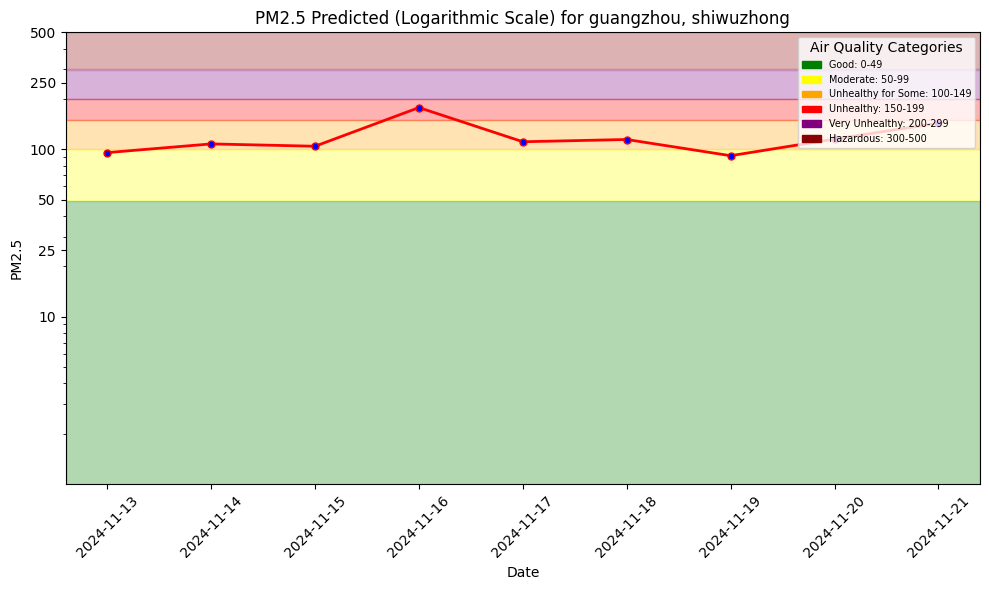

In [12]:
file_path = "./imgs/pm25_forecast.png"
plt = util.plot_air_quality_forecast(city, street, batch_data, file_path)
plt.show()

In [15]:
# Get or create feature group
monitor_fg = fs.get_or_create_feature_group(
    name='aq_predictions',
    description='Air Quality prediction monitoring',
    version=1,
    primary_key=['city','street','date','days_before_forecast_day'],
    event_time="date"
)

In [19]:
batch_data['temperature_2m_mean'] = batch_data['temperature_2m_mean'].astype('float32')
batch_data['precipitation_sum'] = batch_data['precipitation_sum'].astype('float32')
batch_data['wind_speed_10m_max'] = batch_data['wind_speed_10m_max'].astype('float32')
batch_data['wind_direction_10m_dominant'] = batch_data['wind_direction_10m_dominant'].astype('float32')



monitor_fg.insert(batch_data, write_options={"wait_for_job": True})


Uploading Dataframe: 0.00% |          | Rows 0/9 | Elapsed Time: 00:00 | Remaining Time: ?

Launching job: aq_predictions_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/1157273/jobs/named/aq_predictions_1_offline_fg_materialization/executions


(<hsfs.core.job.Job at 0x7fbe79fcad00>, None)

In [20]:
# We will create a hindcast chart for  only the forecasts made 1 day beforehand
monitoring_df = monitor_fg.filter(monitor_fg.days_before_forecast_day == 1).read(read_options={"use_hive": True})
monitoring_df

Finished: Reading data from Hopsworks, using Hive (2.01s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25,street,country,days_before_forecast_day
0,2024-11-17,24.40,0.0,14.058450,39.805527,guangzhou,110.97746,shiwuzhong,china,1
1,2024-11-10,22.75,0.0,12.074766,26.564985,guangzhou,122.51412,shiwuzhong,china,1


In [21]:
air_quality_fg = fs.get_feature_group(
    name='air_quality',
    version=1,
)
air_quality_df = air_quality_fg.read(read_options={"use_hive": True})
air_quality_df

Finished: Reading data from Hopsworks, using Hive (3.49s) 


,date,pm25,country,city,street,url
0,2018-12-10,53.0,china,guangzhou,shiwuzhong,https://api.waqi.info/feed/@9846
1,2014-06-12,128.0,china,guangzhou,shiwuzhong,https://api.waqi.info/feed/@9846
2,2015-01-26,168.0,china,guangzhou,shiwuzhong,https://api.waqi.info/feed/@9846
3,2014-12-18,84.0,china,guangzhou,shiwuzhong,https://api.waqi.info/feed/@9846
4,2016-04-02,119.0,china,guangzhou,shiwuzhong,https://api.waqi.info/feed/@9846
...,...,...,...,...,...,...
3913,2021-01-06,142.0,china,guangzhou,shiwuzhong,https://api.waqi.info/feed/@9846
3914,2024-07-07,28.0,china,guangzhou,shiwuzhong,https://api.waqi.info/feed/@9846
3915,2021-04-10,114.0,china,guangzhou,shiwuzhong,https://api.waqi.info/feed/@9846
3916,2024-11-10,149.0,china,guangzhou,shiwuzhong,https://api.waqi.info/feed/@9846


In [22]:
outcome_df = air_quality_df[['date', 'pm25']]
preds_df =  monitoring_df[['date', 'predicted_pm25']]

hindcast_df = pd.merge(preds_df, outcome_df, on="date")
hindcast_df = hindcast_df.sort_values(by=['date'])


In [23]:
print(hindcast_df.dtypes)

date              datetime64[ns]
predicted_pm25           float64
pm25                     float64
dtype: object


In [24]:
hindcast_df

,date,predicted_pm25,pm25
0,2024-11-10,122.51412,149.0


In [25]:
features_df = weather_fg.read(read_options={"use_hive": True})
features_df = features_df.sort_values(by=['date'], ascending=True)
features_df = features_df.tail(10)

Finished: Reading data from Hopsworks, using Hive (3.19s) 


In [26]:
features_df['predicted_pm25'] = retrieved_xgboost_model.predict(features_df[['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']])

In [27]:
features_df['temperature_2m_mean'] = features_df['temperature_2m_mean'].astype('float32')
features_df['precipitation_sum'] = features_df['precipitation_sum'].astype('float32')
features_df['wind_speed_10m_max'] = features_df['wind_speed_10m_max'].astype('float32')
features_df['wind_direction_10m_dominant'] = features_df['wind_direction_10m_dominant'].astype('float32')

In [28]:
df = pd.merge(features_df, air_quality_df[['date', 'pm25', 'street', 'country']], on="date")

In [29]:
df['days_before_forecast_day'] = 1
hindcast_df = df
df = df.drop('pm25', axis=1)

In [30]:
monitor_fg.insert(df, write_options={"wait_for_job": True})

Uploading Dataframe: 0.00% |          | Rows 0/1 | Elapsed Time: 00:00 | Remaining Time: ?

Launching job: aq_predictions_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/1157273/jobs/named/aq_predictions_1_offline_fg_materialization/executions


(<hsfs.core.job.Job at 0x7fbe79fcad00>, None)

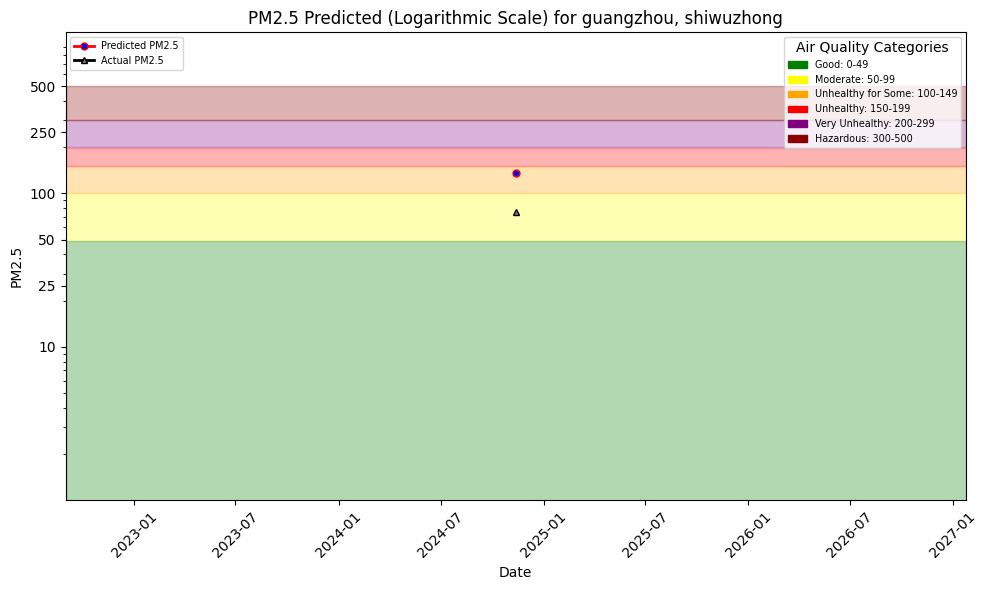

In [31]:
file_path = "./imgs/pm25_hindcast_1day.png"
plt = util.plot_air_quality_forecast(city, street, hindcast_df, file_path, hindcast=True)
plt.show()